In [22]:
import sys
sys.path.append('../src')

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from rbf_network import evaluate_sigma
import time
import os


X = scipy.io.loadmat('../data/data_train.mat')['data_train']
y = scipy.io.loadmat('../data/label_train.mat')['label_train'].flatten()


D = cdist(X, X, metric='euclidean')

np.fill_diagonal(D, np.inf)
sigma_min = np.median(np.min(D, axis=1))
np.fill_diagonal(D, 0)
sigma_max = D.max()

print(f"Data loaded: X {X.shape}, y {y.shape}")
print(f"σ range: [{sigma_min:.4f}, {sigma_max:.4f}]")

Data loaded: X (301, 33), y (301,)
σ range: [1.6018, 17.9523]


In [23]:
# Generate 5 coarse sigma candidates
sigma_coarse = np.logspace(np.log10(sigma_min), np.log10(sigma_max), 5)
print(sigma_coarse)

[ 1.60184149  2.93085893  5.36253688  9.81173181 17.95233922]


In [24]:
coarse_results = []

for i, sigma in enumerate(sigma_coarse, 1):
    print(f"\n[{i}/5] σ = {sigma:.4f}")
    cv_acc, H, selected = evaluate_sigma(sigma, X, y, verbose=False)
    
    coarse_results.append({
        'sigma': sigma,
        'cv_acc': cv_acc,
        'H': H,
        'selected': selected
    })
    
    print(f"  CV Accuracy: {cv_acc:.4f}")
    print(f"  H neurons  : {H}")



print("COARSE SEARCH RESULTS:")
for i, res in enumerate(coarse_results, 1):
    print(f"σ_{i} = {res['sigma']:7.4f}  →  CV = {res['cv_acc']:.4f}  (H = {res['H']:2d})")


[1/5] σ = 1.6018
  CV Accuracy: 0.7771
  H neurons  : 3

[2/5] σ = 2.9309
  CV Accuracy: 0.8070
  H neurons  : 4

[3/5] σ = 5.3625
  CV Accuracy: 0.8836
  H neurons  : 7

[4/5] σ = 9.8117
  CV Accuracy: 0.8870
  H neurons  : 5

[5/5] σ = 17.9523
  CV Accuracy: 0.8671
  H neurons  : 7
COARSE SEARCH RESULTS:
σ_1 =  1.6018  →  CV = 0.7771  (H =  3)
σ_2 =  2.9309  →  CV = 0.8070  (H =  4)
σ_3 =  5.3625  →  CV = 0.8836  (H =  7)
σ_4 =  9.8117  →  CV = 0.8870  (H =  5)
σ_5 = 17.9523  →  CV = 0.8671  (H =  7)


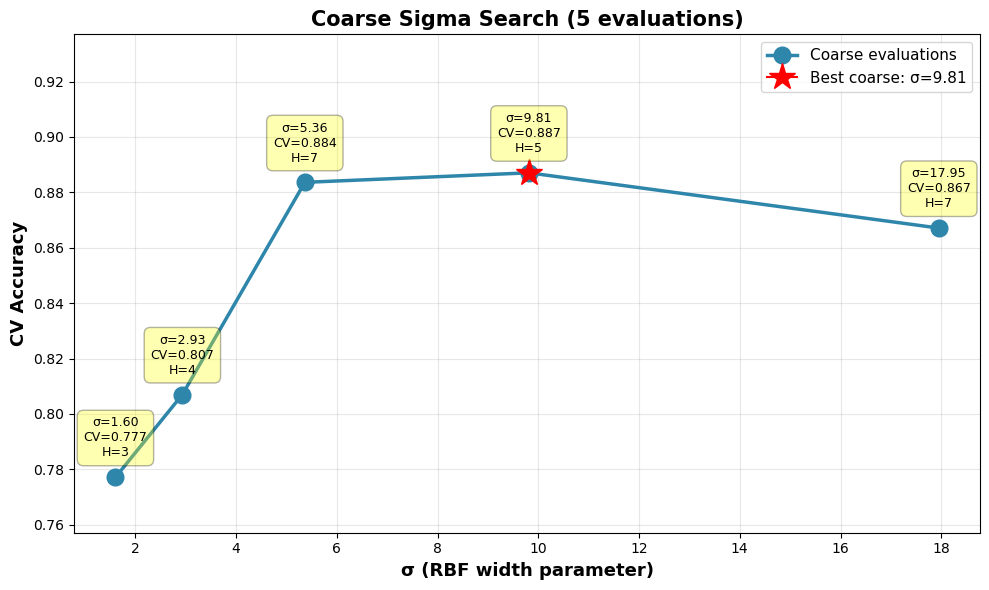

In [25]:
#plot
coarse_sigmas = [r['sigma'] for r in coarse_results]
coarse_accs = [r['cv_acc'] for r in coarse_results]
coarse_H = [r['H'] for r in coarse_results]

# sigma vs CV accuracy
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(coarse_sigmas, coarse_accs,  marker='o', markersize=12, linewidth=2.5, color='#2E86AB', label='Coarse evaluations')

# Annotate each point
for i, (sigma, acc, h) in enumerate(zip(coarse_sigmas, coarse_accs, coarse_H)):
    ax.annotate(f'σ={sigma:.2f}\nCV={acc:.3f}\nH={h}', xy=(sigma, acc), xytext=(0, 15), textcoords='offset points', ha='center',fontsize=9,bbox=dict(boxstyle='round,pad=0.5',  facecolor='yellow', alpha=0.3))

# Highlight best
best_coarse_idx = np.argmax(coarse_accs)
ax.plot(coarse_sigmas[best_coarse_idx], 
        coarse_accs[best_coarse_idx],
        marker='*', markersize=20, 
        color='red', 
        label=f'Best coarse: σ={coarse_sigmas[best_coarse_idx]:.2f}')

ax.set_xlabel('σ (RBF width parameter)', fontsize=13, fontweight='bold')
ax.set_ylabel('CV Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Coarse Sigma Search (5 evaluations)', 
             fontsize=15, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(fontsize=11)
ax.set_ylim([min(coarse_accs) - 0.02, max(coarse_accs) + 0.05])

plt.tight_layout()
plt.savefig('../plots/sigma_coarse_search.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Define search region for golden section
if best_coarse_idx == 0:
    # Peak at left boundary
    region_low = sigma_coarse[0]
    region_high = sigma_coarse[1]
    print(f"Peak at LEFT boundary → search [{region_low:.4f}, {region_high:.4f}]")
elif best_coarse_idx == 4:
    # Peak at right boundary
    region_low = sigma_coarse[3]
    region_high = sigma_coarse[4]
    print(f"Peak at RIGHT boundary → search [{region_low:.4f}, {region_high:.4f}]")
else:
    # Peak in middle
    region_low = sigma_coarse[best_coarse_idx - 1]
    region_high = sigma_coarse[best_coarse_idx + 1]
    print(f"Peak in MIDDLE → search [{region_low:.4f}, {region_high:.4f}]")

print(f"Region width: {region_high - region_low:.4f}")

Peak in MIDDLE → search [5.3625, 17.9523]
Region width: 12.5898


In [27]:
print("GOLDEN SECTION SEARCH (30 iterations)")

golden_ratio = 0.618
low = region_low
high = region_high

golden_results = []

for iteration in range(1, 31):
    print(f"\n[Iteration {iteration}/30]")
    print(f"  Current interval: [{low:.4f}, {high:.4f}]")
    print(f"  Width: {high - low:.4f}")
    
    # Two probe points
    sigma_a = low + (1 - golden_ratio) * (high - low)
    sigma_b = low + golden_ratio * (high - low)
    
    print(f"  Testing: σ_a = {sigma_a:.4f}, σ_b = {sigma_b:.4f}")
    
    # Evaluate both
    cv_a, H_a, sel_a = evaluate_sigma(sigma_a, X, y, verbose=False)
    cv_b, H_b, sel_b = evaluate_sigma(sigma_b, X, y, verbose=False)
    
    print(f"  Results: CV_a = {cv_a:.4f} (H={H_a}), CV_b = {cv_b:.4f} (H={H_b})")
    
    # Store results
    golden_results.append({
        'iteration': iteration,
        'sigma_a': sigma_a,
        'sigma_b': sigma_b,
        'cv_a': cv_a,
        'cv_b': cv_b,
        'H_a': H_a,
        'H_b': H_b
    })
    
    # Update interval
    if cv_a > cv_b:
        high = sigma_b
        print(f"  → Discard right, new interval: [{low:.4f}, {high:.4f}]")
    else:
        low = sigma_a
        print(f"  → Discard left, new interval: [{low:.4f}, {high:.4f}]")

# Final best sigma
best_sigma = (low + high) / 2

print("\nGOLDEN SECTION SEARCH CONVERGED")
print(f"Best σ: {best_sigma:.4f}")
print(f"Final interval: [{low:.4f}, {high:.4f}]")
print(f"Interval width: {high - low:.4f}")

GOLDEN SECTION SEARCH (30 iterations)

[Iteration 1/30]
  Current interval: [5.3625, 17.9523]
  Width: 12.5898
  Testing: σ_a = 10.1718, σ_b = 13.1430
  Results: CV_a = 0.9002 (H=7), CV_b = 0.8836 (H=11)
  → Discard right, new interval: [5.3625, 13.1430]

[Iteration 2/30]
  Current interval: [5.3625, 13.1430]
  Width: 7.7805
  Testing: σ_a = 8.3347, σ_b = 10.1709
  Results: CV_a = 0.9102 (H=5), CV_b = 0.9002 (H=7)
  → Discard right, new interval: [5.3625, 10.1709]

[Iteration 3/30]
  Current interval: [5.3625, 10.1709]
  Width: 4.8083
  Testing: σ_a = 7.1993, σ_b = 8.3341
  Results: CV_a = 0.9136 (H=6), CV_b = 0.9102 (H=5)
  → Discard right, new interval: [5.3625, 8.3341]

[Iteration 4/30]
  Current interval: [5.3625, 8.3341]
  Width: 2.9716
  Testing: σ_a = 6.4977, σ_b = 7.1990
  Results: CV_a = 0.9236 (H=9), CV_b = 0.9136 (H=6)
  → Discard right, new interval: [5.3625, 7.1990]

[Iteration 5/30]
  Current interval: [5.3625, 7.1990]
  Width: 1.8364
  Testing: σ_a = 6.0641, σ_b = 6.4974

In [28]:
print("FINAL EVALUATION AT BEST SIGMA")

final_cv, final_H, final_selected = evaluate_sigma(best_sigma, X, y, verbose=True)

print("FINAL RESULTS")
print(f"Best σ           : {best_sigma:.4f}")
print(f"CV Accuracy      : {final_cv:.4f}")
print(f"H (neurons)      : {final_H}")
print(f"Selected neurons : {final_selected}")

FINAL EVALUATION AT BEST SIGMA
Evaluating σ = 6.5198
  RBF transform: (301, 33) → (301, 301)
  J scores computed: max=0.5023, min=0.0001
  Selected 9 neurons, CV accuracy = 0.9236
FINAL RESULTS
Best σ           : 6.5198
CV Accuracy      : 0.9236
H (neurons)      : 9
Selected neurons : [79, 129, 201, 62, 115, 192, 89, 291, 300]


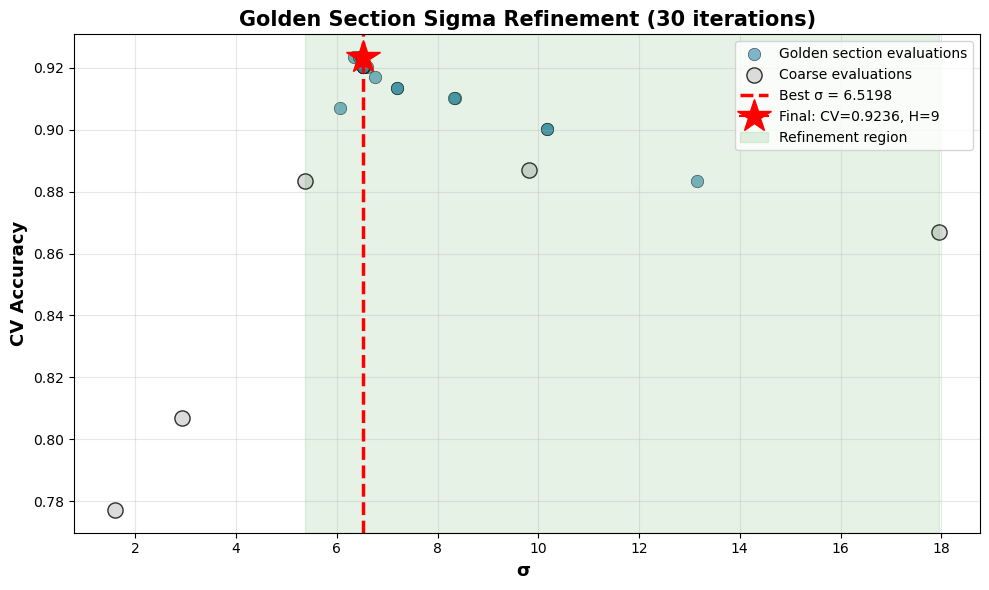

In [29]:
# Extract golden section results
golden_sigmas = []
golden_accs = []

for res in golden_results:
    golden_sigmas.extend([res['sigma_a'], res['sigma_b']])
    golden_accs.extend([res['cv_a'], res['cv_b']])

# Golden Section Refinement
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all golden section points
ax.scatter(golden_sigmas, golden_accs,
          s=80, alpha=0.6, color='#2E86AB',
          label='Golden section evaluations',
          edgecolors='black', linewidth=0.5)

# Plot coarse points for reference
ax.scatter(coarse_sigmas, coarse_accs,
          s=120, alpha=0.8, color='lightgray',
          marker='o', label='Coarse evaluations',
          edgecolors='black', linewidth=1)

# Highlight final best sigma
ax.axvline(best_sigma, color='red', linestyle='--',
          linewidth=2.5, label=f'Best σ = {best_sigma:.4f}')

# Mark the final result
ax.plot(best_sigma, final_cv,
       marker='*', markersize=25,
       color='red',
       label=f'Final: CV={final_cv:.4f}, H={final_H}')

# Mark the search region boundaries
ax.axvspan(region_low, region_high, alpha=0.1, color='green',
          label=f'Refinement region')

ax.set_xlabel('σ ', fontsize=13, fontweight='bold')
ax.set_ylabel('CV Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Golden Section Sigma Refinement (30 iterations)', 
            fontsize=15, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(fontsize=10, loc='best')

plt.tight_layout()
plt.savefig('../plots/golden_section_refinement.png', dpi=300, bbox_inches='tight')
plt.show()


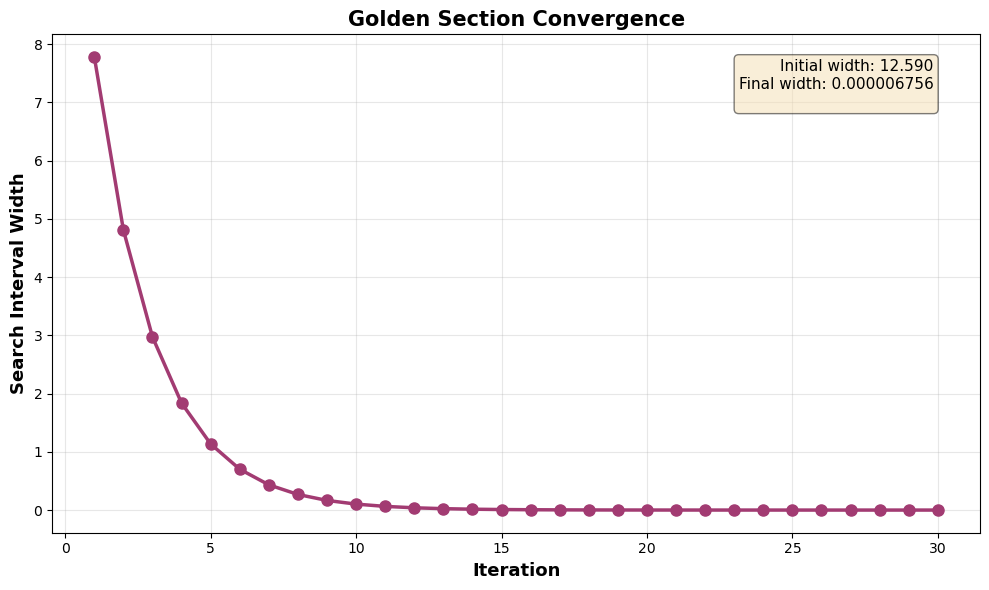

In [32]:
#Convergence over iterations 
fig, ax = plt.subplots(figsize=(10, 6))

# Show interval width shrinking
iterations = [r['iteration'] for r in golden_results]
interval_widths = []

low_temp = region_low
high_temp = region_high

for res in golden_results:
    if res['cv_a'] > res['cv_b']:
        high_temp = res['sigma_b']
    else:
        low_temp = res['sigma_a']
    interval_widths.append(high_temp - low_temp)

ax.plot(iterations, interval_widths,
       marker='o', linewidth=2.5, markersize=8,
       color='#A23B72')

ax.set_xlabel('Iteration', fontsize=13, fontweight='bold')
ax.set_ylabel('Search Interval Width', fontsize=13, fontweight='bold')
ax.set_title('Golden Section Convergence', 
            fontsize=15, fontweight='bold')
ax.grid(alpha=0.3)

# Annotate reduction
initial_width = region_high - region_low
final_width = interval_widths[-1]
reduction_pct = (1 - final_width/initial_width) * 100

ax.text(0.95, 0.95, 
       f'Initial width: {initial_width:.3f}\n'
       f'Final width: {final_width:.9f}\n'
       #f'Reduction: {reduction_pct:.1f}%'
       ,transform=ax.transAxes,
       fontsize=11,
       verticalalignment='top',
       horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../plots/convergence.png', dpi=300, bbox_inches='tight')
plt.show()


In [34]:

print(f"Total evaluations: {5 + 30*2} ")
print(f"Best σ found     : {best_sigma:.4f}")
print(f"Best CV accuracy : {final_cv:.4f}")
print(f"Optimal H        : {final_H}")


Total evaluations: 65 
Best σ found     : 6.5198
Best CV accuracy : 0.9236
Optimal H        : 9
